In [56]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

# Set seaborn theme
sb.set_theme()

In [57]:
# Load datasets
training_data = pd.read_csv("customer_churn_dataset-training-master.csv")
test_data = pd.read_csv("customer_churn_dataset-testing-master.csv")

# Standardize column headers
training_data.columns = [col.lower().replace(" ", "_") for col in training_data.columns]
test_data.columns = training_data.columns  # ensure test data matches structure

In [58]:
print("Training Data Shape:", training_data.shape)
print("Columns:", training_data.columns.tolist())
print(training_data.head())
print("Data types:\n", training_data.dtypes)
print("Missing values:\n", training_data.isnull().sum())

Training Data Shape: (440833, 12)
Columns: ['customerid', 'age', 'gender', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'subscription_type', 'contract_length', 'total_spend', 'last_interaction', 'churn']
   customerid   age  gender  tenure  usage_frequency  support_calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   payment_delay subscription_type contract_length  total_spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0

In [59]:
print("Churn counts:\n", training_data['churn'].value_counts())
print("Churn ratio:\n", training_data['churn'].value_counts(normalize=True))

Churn counts:
 churn
1.0    249999
0.0    190833
Name: count, dtype: int64
Churn ratio:
 churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64


In [60]:
training_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [61]:
features = training_data.iloc[:, 1:-1]   # Remove customerid and churn
target = training_data['churn']

test_features = test_data.iloc[:, 1:-1]
test_target = test_data['churn']

In [62]:
for col in features.select_dtypes(include='object').columns:
    print(f"{col} value counts:\n", features[col].value_counts(dropna=False), "\n")

gender value counts:
 gender
Male      250252
Female    190580
Name: count, dtype: int64 

subscription_type value counts:
 subscription_type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64 

contract_length value counts:
 contract_length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64 



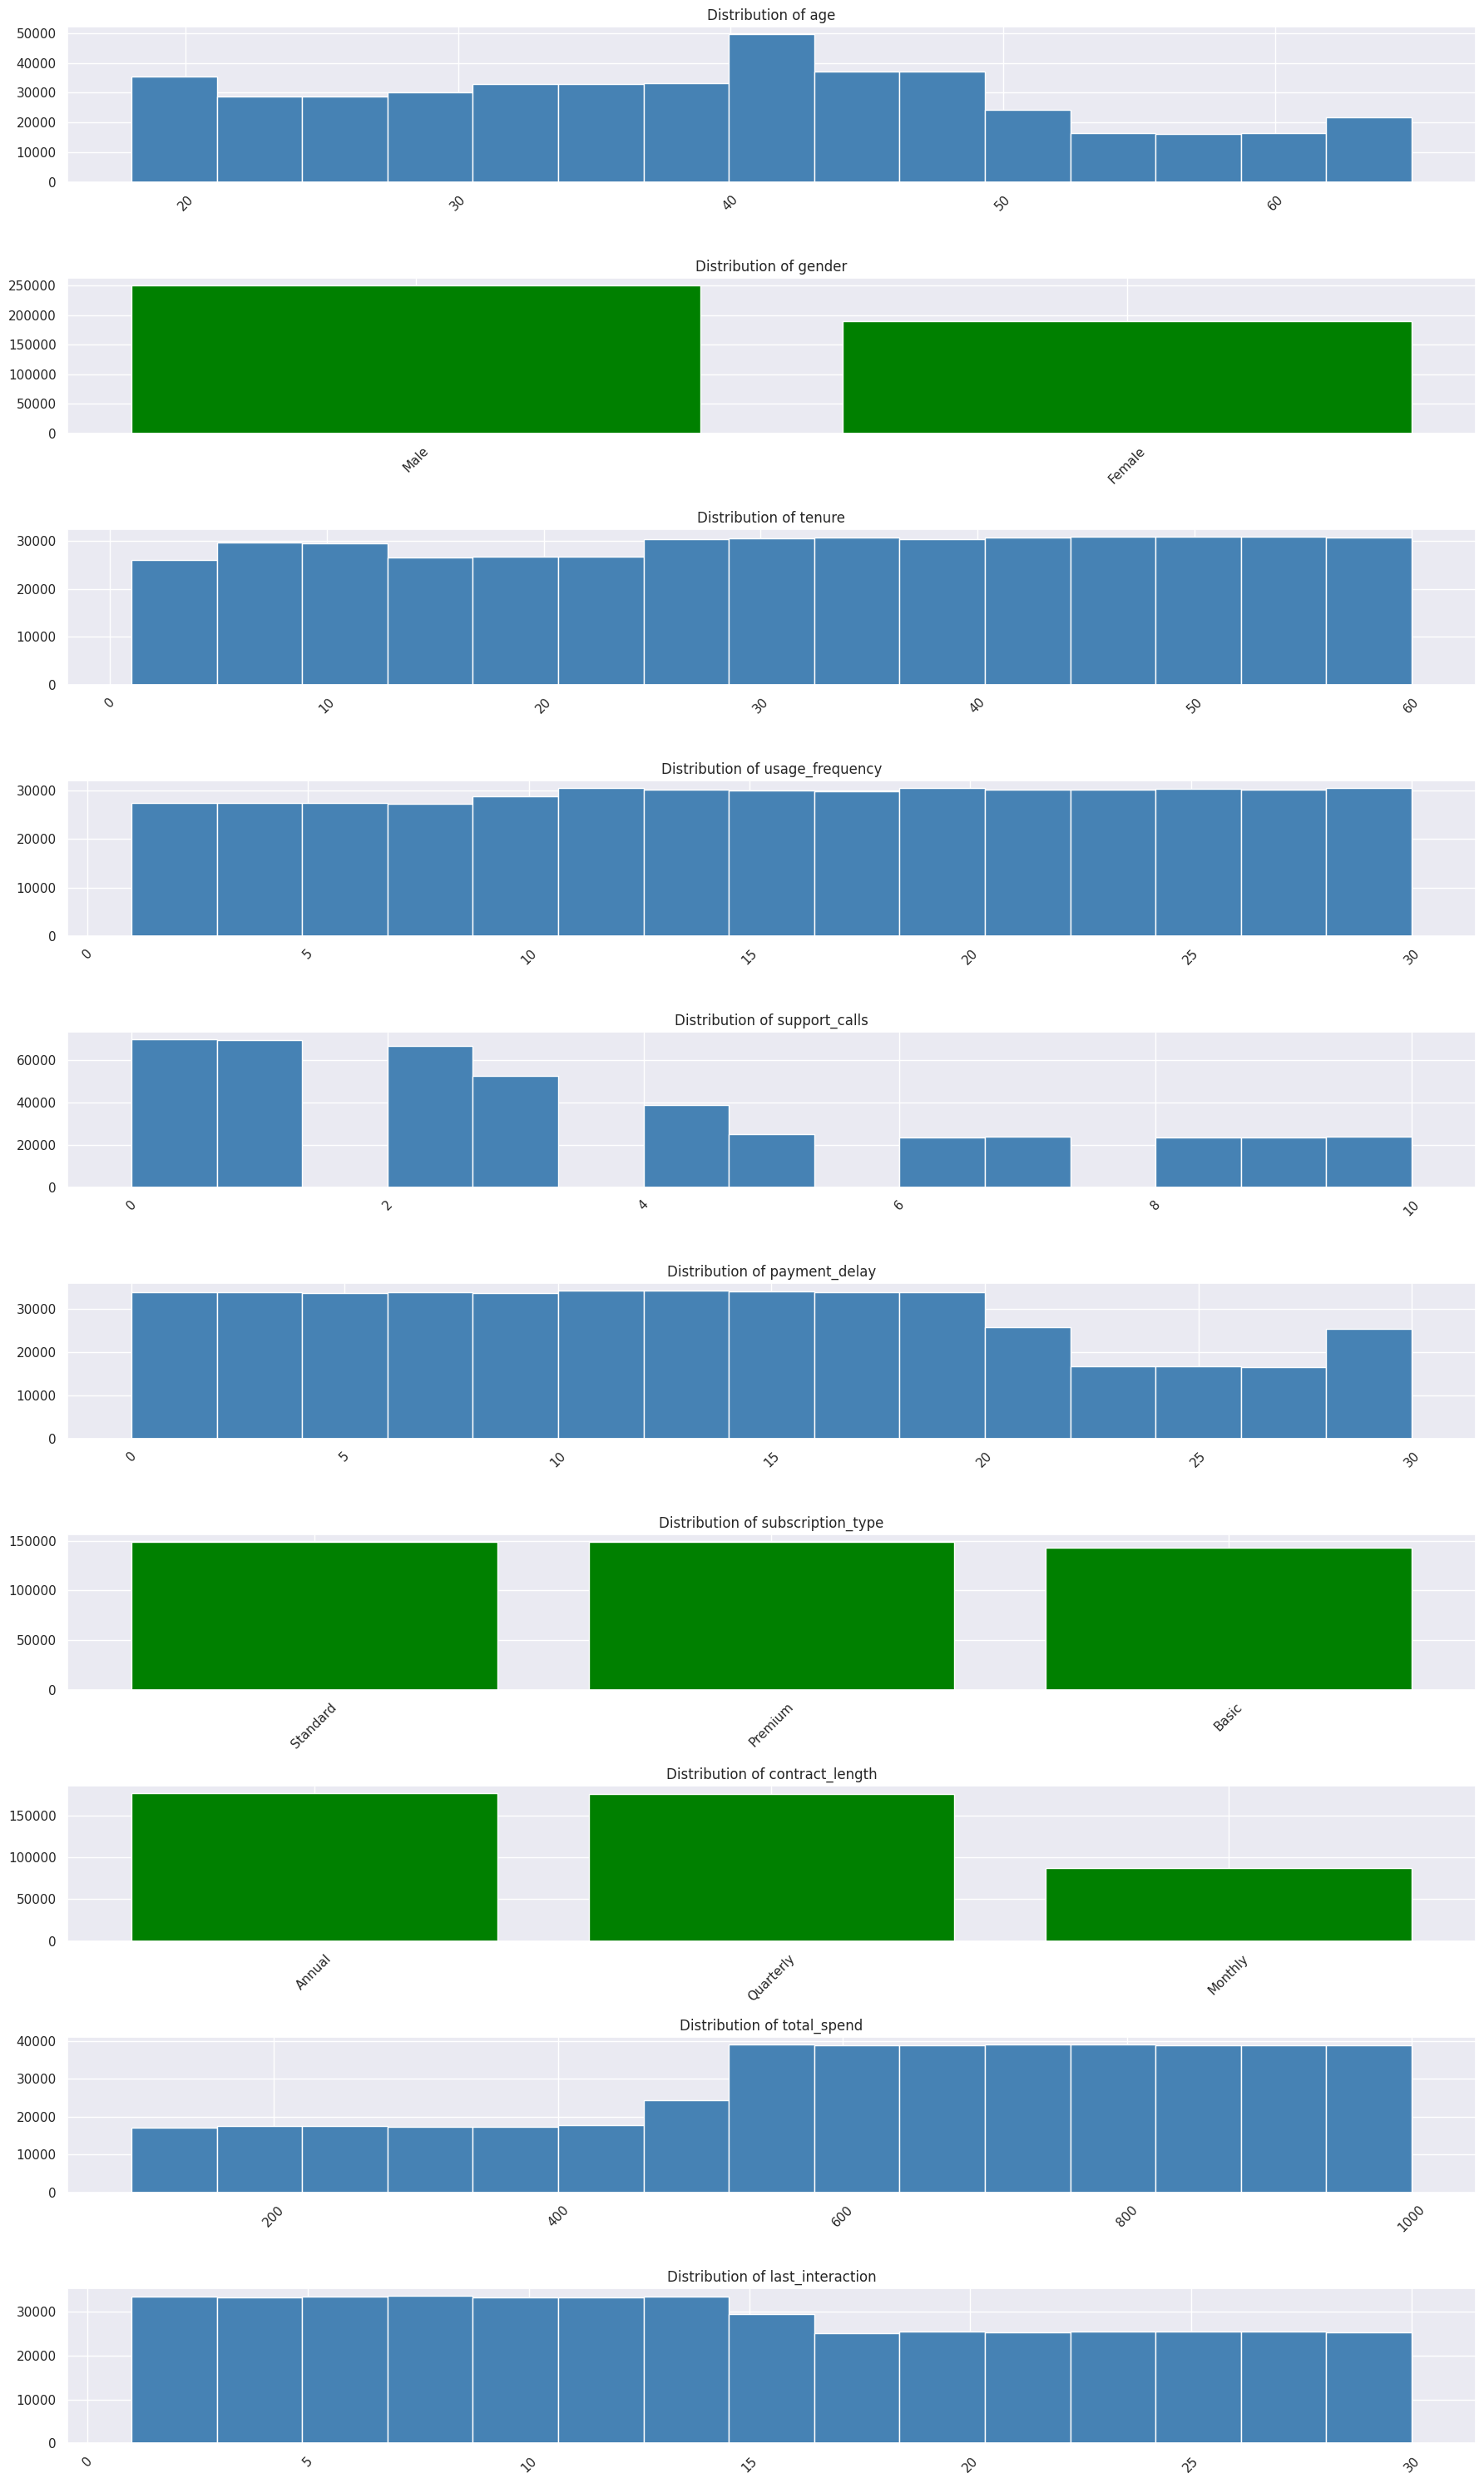

In [63]:
num_features = len(features.columns)

fig, axs = plt.subplots(nrows=num_features, figsize=(18, num_features * 3))

# Ensure axs is iterable
if num_features == 1:
    axs = [axs]

# Plot each feature
for i, feature in enumerate(features.columns):
    ax = axs[i]
    if features[feature].dtype != "object":
        ax.hist(features[feature], bins=15, color="steelblue")
    else:
        ax.bar(
            features[feature].value_counts().index.astype(str),
            features[feature].value_counts().values,
            color="green"
        )
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [64]:
encoded_features = features.copy()
encoded_test_features = test_features.copy()
label_encoders = {}

for col in encoded_features.columns:
    if encoded_features[col].dtype == 'object':
        print(f"Encoding: {col}")
        le = LabelEncoder()
        encoded_features[col] = le.fit_transform(encoded_features[col])
        encoded_test_features[col] = le.transform(encoded_test_features[col])
        label_encoders[col] = le

Encoding: gender
Encoding: subscription_type
Encoding: contract_length


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:41:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5034175288159816
Precision: 0.48818569459138855
Recall: 0.9987210179385433
F1 Score: 0.6558061911170928
Confusion Matrix:
 [[ 1953 31928]
 [   39 30454]]


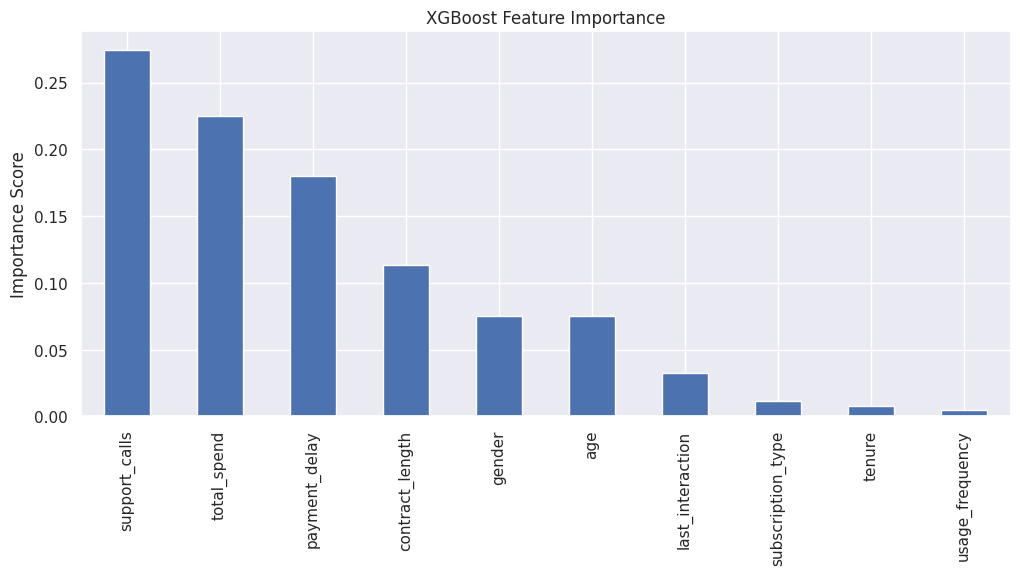

In [65]:
# Scale features
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd

scaler = RobustScaler()
scaled_features = scaler.fit_transform(encoded_features)
scaled_test_features = scaler.transform(encoded_test_features)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(scaled_features, target)

# Predict on test data
xgb_preds = xgb.predict(scaled_test_features)

# Evaluate
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(test_target, xgb_preds))
print("Precision:", metrics.precision_score(test_target, xgb_preds))
print("Recall:", metrics.recall_score(test_target, xgb_preds))
print("F1 Score:", metrics.f1_score(test_target, xgb_preds))
print("Confusion Matrix:\n", metrics.confusion_matrix(test_target, xgb_preds))

# Feature Importance Plot
importances = pd.Series(xgb.feature_importances_, index=encoded_features.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title='XGBoost Feature Importance')
plt.ylabel("Importance Score")
plt.show()